In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

For this case study, we use the input-output data of Germany. The data for the initial output level and final consumption level per industry as well as the supply and demand shock data is taken from:

Pichler, A. and Farmer, J. D. (2021b). Simultaneous supply and demand constraints in
input–output networks: the case of covid-19 in Germany, Italy and Spain (Version V1).
Zenodo. https://doi.org/10.5281/zenodo.4326815

## Final consumption

**We define the initial and maximal consumption for each industry**

In [2]:
fdata = pd.read_csv('fdata_deu.csv', sep = ',')
fdata.head()
f_0 = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))

In [3]:
demand_shock = np.zeros(f_max.shape[0])
for i in range (0,f_max.shape[0]):
    demand_shock[i] = round(1- f_max[i]/f_0[i],3)
    
print(demand_shock) # ok 
demand_shock = np.array(demand_shock)

[0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.099 0.081
 0.1   0.1   0.1   0.1   0.099 0.1   0.1   0.1   0.099 0.099 0.1   0.023
 0.015 0.036 0.1   0.1   0.098 0.095 0.569 0.114 0.503 0.223 0.034 0.731
 0.038 0.043 0.011 0.088 0.029 0.013 0.02  0.002 0.093 0.094 0.083 0.1
 0.035 0.042 0.002 0.007 0.001 0.043 0.   ]


## Total output

In [4]:
xdata =  pd.read_csv('xdata_deu.csv', sep = ',')
xdata.tail()   
x_0 = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

In [5]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x_0[i],6)
    
print(supply_shock) # ok: corresonds to the data 
supply_shock = np.array(supply_shock)

[0.       0.849999 0.       0.483204 0.       0.685309 0.730686 0.342704
 0.       0.       0.189825 0.       0.352529 0.639448 0.726353 0.662572
 0.430758 0.630639 0.618354 0.696668 0.597033 0.652042 0.606449 0.
 0.       0.       0.715557 0.180259 0.       0.246592 0.       0.
 0.       0.       0.       0.646411 0.       0.       0.       0.07215
 0.       0.       0.       0.512768 0.362812 0.459166 0.410839 0.396788
 0.19581  0.426938 0.       0.       0.       0.611961 0.      ]


# IO table 

In [6]:
df = pd.read_csv('deu_wiot.csv',sep = ',',low_memory=False)
df.head()
df = df.iloc[:,1:]# leaving out industries U and T
df = df.astype('float')
df.shape

(55, 55)

In [7]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

In [8]:
Z = pd.read_csv('Zmatrix_deu.csv', sep=',', low_memory=False)
Z =  Z.iloc[:,1:]# leaving out industries U and T
Z = Z.astype('float')
Z = np.array(Z)
N = Z.shape[0]

In [9]:
x_0 = np.array(x_0)
f_0 = np.array(f_0)

# Leontief Model

**Computing equilibrium when x is given**

In [10]:
final_consumption = np.matmul(np.identity(N)-A, x_0)
sum(f_max)/sum(final_consumption) #It holds that f_0 = final_consumption = (I-A)x

0.9132079048009196

**Computing equilibrium when f is given**

In [11]:
L = np.linalg.inv(np.identity(N)-A)

In [12]:
total_output = np.matmul(L, f_0)
sum(x_max)/sum(total_output)
#sum(x_max)/sum(x_0) 

0.6913968179397179

**Computing direct shock:**

In [13]:
direct_shocks = np.ones(N)
for i in range(N):
    direct_shocks[i] = x_max[i]/x_0[i]
direct_shocks

array([1.        , 0.15000126, 1.        , 0.51679628, 1.        ,
       0.31469054, 0.26931379, 0.6572959 , 1.        , 1.        ,
       0.81017476, 1.        , 0.647471  , 0.36055197, 0.27364727,
       0.33742774, 0.56924176, 0.36936085, 0.38164598, 0.30333159,
       0.40296703, 0.34795813, 0.39355072, 1.        , 1.        ,
       1.        , 0.28444251, 0.819741  , 1.        , 0.7534085 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.35358853, 1.        , 1.        , 1.        , 0.92784965,
       1.        , 1.        , 1.        , 0.4872323 , 0.63718792,
       0.54083352, 0.58916126, 0.60321244, 0.80418999, 0.57306249,
       1.        , 1.        , 1.        , 0.38803934, 1.        ])

In [14]:
direct_shock = (sum(x_max)/sum(x_0),sum(f_max)/sum(f_0))
direct_shock

(0.6913968179397156, 0.9132079048009223)

# Optimalization

### Feasible Market Allocations
Given exogenous constraints to supply and demand, what is the feasible market allocation that maximizes final consumption and/or total output? The solution needs to lie within exogenous bounds on supply and demand and also needs to satisfy the assumption of Leontief production:

$$ x = Ax + f = Lf $$

We seek market allocations {$x^*$ , $f^*$} that (a) respect the given production recipes $x^*=Lf^*$ and (b) satisfy basic output and demand constraints $x^* \in [0, x^{max}]$ and $f^* \in [0, f^{max}]$.

**Optimization procedure**

As a first case, we determine the market allocation that maximizes gross output under the assumptions specified. Large levels of output indicate high levels of ecomomic activity, which in turn entail high levels of primary factors such as labor compensation. As a second case, we look at market allocations that maximize final comsumption given current production capacities. Due to the linearity of the Leontief framework, the problem boils down to linear programming exercises.

*Maximizing gross output*
$$ \text{max}_f \qquad 1^T(I-A)^{-1}f $$
$$ \text{Subject to} \quad (I-A)^{-1}f \in [0, x^{max}] $$

*Maximizing final consumption*
$$ \text{max}_x \qquad 1^T(I-A)x $$
$$ \text{Subject to} \quad (I-A)x \in [0, f^{max}] $$

### Maximizing total output

In [16]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return result.success, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [17]:
result = max_output(N,L,A,x_max,f_max)
Max_output = (result[1], result[2])
Max_output

(0.6251353593714393, 0.6320096267938023)

### Maximizing final consumption

In [18]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

In [19]:
result2 = max_consumption(N,L,A,x_max,f_max)
Max_consumption = (result2[1], result2[2])

**Note that both optimization problems give almost the same solution**

# Rationing

In [20]:
f_max = f_max[:54]
x_max = x_max[:54]
A = A[:54,:54]
Z = Z[:54,:54]
N = 54
x_0 = x_0[:54]
f_0 = f_0[:54]
L = np.linalg.inv(np.identity(N)-A)
supply_shock = np.array(supply_shock[:54])
demand_shock = np.array(demand_shock[:54])

### Input bottlenecks and rationing variations
In contrast to the optimization methods, this represents a bottom-up approach for finding feasible market allocations. Industries place orders to their suppliers based on incoming demand. Since suppliers can be output constrained, they might not be able to satisfy demand fully. A supplier therefore needs to make a decision about how much of each customer’s demand it serves. Intermediate consumers transform inputs to outputs based on fixed production recipes. Thus if a customer receives less inputs than she asked for, she faces an input bottleneck further constraining her production. As a consequence, the customer reduces her demand for other inputs as they are not further needed under limited productive capacities. We iterate this procedure forward until the algorithm converges.

**Strict Proportional Rationing**

If industries are unable to satisfy total incoming demand completely, they distribute output proportional to their customers’ demand, where no distinction is made between intermediate and final customers. We implement the rationing algorithm in the following way:
1. Industries determine their total demand as if there were no supply-side constraints, $d = Lf^{\text{max}}$;
2. Industries evaluate if they are able to satisfy demand goven their constrained production capacities;
3. Industries that only partially satisfy demand, create a bottleneck;
4. Industries reduce their production according to the largest input bottleneck (assumption of fixed recipes);
5. The total amount of goods delivered to the final consumer is computed;
6. Iterate 1-5 until there are no input constraints left.

Formulas:

$$ r_i[t] = \frac{x_i^{\text{max}}}{d_i[t]} $$

$$ s_i[t] = min_j \{r_j[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

*Implementation*

In [21]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0: 
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t, x[t-1]


In [22]:
result_proportional = algo_proportional(A, L, f_max, x_max, TT = 30, prioritize="no")
result_proportional[:3]

(0.1512270465545405, 0.1521682361425501, 3)

## Mixed priority/proportional rationing

We implement the rationing algorithm in the following way:
1. Industries determine their total demand as if there were no supply-side constraints, $d = Lf^{\text{max}}$;
2. Industries evaluate if they are able to satisfy demand given their constrained production capacities;
3. Industries that only partially satisfy demand, create a bottleneck;
4. Industries reduce their production according to the largest input bottleneck (assumption of fixed recipes);
5. The total amount of goods delivered to the final consumer is computed;
6. Iterate 1-5 until there are no input constraints left.

Formulas:

$$ r_i[t] = \frac{x_i^{\text{max}}}{\sum_{j}A_{ij}d_j[t]} $$

$$ s_i[t] = min_j \{r_j[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

*Implementation*

In [23]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/np.matmul(A[i],d[t])
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [24]:
result_mixed = algo_mixed(A, L, f_max, x_max,30, prioritize="yes")
result_mixed

(0.2860294357826111, 0.28787032420594566, 3)

## Priority rationing

Largest first rationing; firms are prioritized over the final consumer. Take
an initial demand vector $f[0] = f$
max as given, implying an initial aggregate demand vector
$d[1] = Lf[0]$. Every firm $i$ ranks each customers based on initial demand size. Let  $h_{ij}$ be the $j$ largest customers of firm $i$: $h_{ij} =
\{k(1), k(2), ..., k(j)
: A_{ik(1)}d_{k(1)} [1] ≥ A_{ik(2)}d_{k(2)} [1] ≥ ... ≥ A_{ik(j)}
d_{k(j)}[1] \}$. By looping over the
index $t = {1, 2, ...}$, the following system is iterated forward:

Formulas:

$$ r_{ij}[t] = \frac{x_i^{\text{max}}}{\sum_{n\in h_{ij}}A_{ih(j)}d_{n_{(j)}}[t]} $$

$$ s_i[t] = min_j \{r_{ji}[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

In [25]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [26]:
def algo_priority(A, L, fmax, xmax, ordered, TT, prioritize="yes"):                 
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
          
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print(x)
        
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
            return(None, None)
        #print(d[t])
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [27]:
names_ordered = order(A,L,f_max)
result_priority = algo_priority(A, L, f_max, x_max, names_ordered, 30, prioritize="yes")
result_priority

(0.0, 0.0, 3)

## Random rationing

Suppliers rank their customers randomly. The computations for this algorithm are the same as for
the priority rationing method. The only difference is the ranking $h_{ij}$ of the customers of
each industry $i$, which is now randomly taken. We implement the rationing algorithm
by taking the average from $100$ samples.

In [29]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    x = []
    y = []
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N)# we willen nu de indices van de j+1 (j van 0 tot en met N-1) grootste suppliers  
                random_ordered[i].append(random)
                
        result = algo_priority(A, L, fmax, xmax, random_ordered, TT = 25, prioritize="yes")
        if result[0] != None:
            x.append(result[0])
            y.append(result[1])
    return sum(x)/len(x), sum(y)/len(y), len(x)

In [30]:
result_random = algo_random(A, L, f_max, x_max, 100, prioritize = "random")
result_random

(0.015457505666590902, 0.015467094964238788, 100)

### Summary of all the impact predicitions:

In [31]:
print(result_proportional[:2])
print(result_mixed[:2])
print(result_priority[:2])
print(result_random[:2])
print(Max_output[:2])
print(Max_consumption[:2])
print(direct_shock[:2])

(0.1512270465545405, 0.1521682361425501)
(0.2860294357826111, 0.28787032420594566)
(0.0, 0.0)
(0.015457505666590902, 0.015467094964238788)
(0.6251353593714393, 0.6320096267938023)
(0.6251351637109838, 0.6320096267938027)
(0.6913968179397156, 0.9132079048009223)


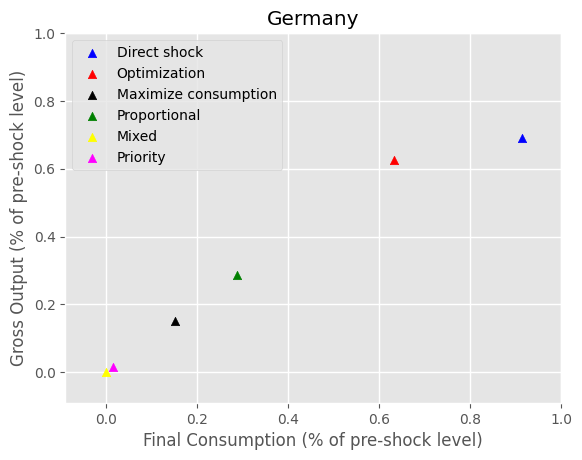

In [32]:
plt.style.use('ggplot')
plt.title("Germany")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.scatter(direct_shock[1], direct_shock[0],marker = '^', color= 'blue')
plt.scatter(Max_consumption[1], Max_consumption[0],marker = '^', color= 'red')
#plt.scatter(Max_output[1], Max_output[0], marker = '^', color='orange')
plt.scatter(result_proportional[1], result_proportional[0], marker = '^', color='black')
plt.scatter(result_mixed[1], result_mixed[0], marker = '^', color='green')
plt.scatter(result_priority[1], result_priority[0], marker = '^', color='yellow')
plt.scatter(result_random[1], result_random[0],marker = '^', color= 'magenta')



#x = np.linspace(-0.09,1.1)
#y = x
#plt.plot(x,y, 'k--', linewidth =0.5)

#plt.text(0.1,0.1,'Proportional')
#plt.text(0.23,0.23,'Mixed')
#plt.text(-0.06,0.04,'Random')
#plt.text(-0.07,-0.05,'Priority')
#plt.text(0.54,0.58, 'Maximize f')
#plt.text(0.55,0.64, 'Maximize x')
#plt.text(0.79,0.71, 'Direct shock')

plt.xlim(-0.09, 1) 
plt.ylim(-0.09, 1)
plt.legend(['Direct shock', 'Optimization', 'Maximize consumption','Proportional','Mixed', 'Priority', 'Random'])
plt.xlabel("Final Consumption (% of pre-shock level)")
plt.ylabel("Gross Output (% of pre-shock level)")
plt.savefig('plot_Germany.png')
plt.show()